In [61]:

import torchvision
import  torch
from torchvision.datasets import CIFAR100
from torchvision.transforms import ToTensor
from  torch import  nn,optim,cuda,from_numpy
from torch.utils import  data
from  torchvision import  datasets,transforms
import  torch.nn.functional as F
import matplotlib.pyplot as plt
import  numpy as np
import  cv2


In [62]:
device ='cuda' if cuda.is_available() else 'cpu'
print(device)

cpu


In [63]:

b_size = 64
train_dataset = datasets.CIFAR100(root="data/",transform = ToTensor(), download = True)

test_dataset = datasets.CIFAR100(root = "data/",transform = ToTensor(),  train = False)

train_data = data.DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_data = data.DataLoader(test_dataset, batch_size=b_size, shuffle=False)


Files already downloaded and verified


In [64]:

print(len(train_dataset))
print(len(test_dataset))


50000
10000


In [65]:
classes = train_dataset.classes 
print('Number of Classes:', len(classes))
print('Class Names :\n', classes)

Number of Classes: 100
Class Names :
 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle

In [66]:

img,label =train_dataset[32]
img_shape=img.shape
img_shape


torch.Size([3, 32, 32])

Label as Number: 39
Label as Name: keyboard


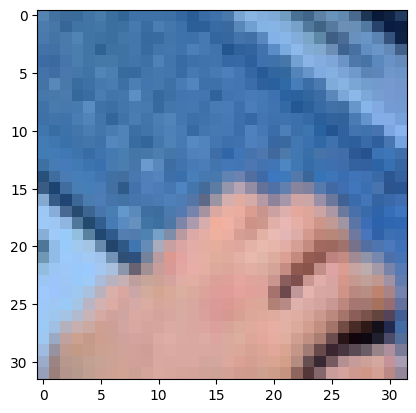

In [67]:

img, label =train_dataset[10]
plt.imshow(img.permute((1,2,0)))
print('Label as Number:', label)
print('Label as Name:', classes[label])


In [68]:
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128,3),
            nn.ReLU(),
            nn.Conv2d(128, 128,3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), #  128 x 8 x 8
            nn.BatchNorm2d(128),

            
            nn.Flatten(), 
            nn.Linear(128*5*5, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 100))
        
    def forward(self, xb):
        return self.network(xb)


model = Cifar10CnnModel()
model.to(device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=3200, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=256, bias=True)
    (16): ReLU()
    (17): Linear(in_features=256, out_features=100, bias=True)
  )
)

In [69]:
criterion = nn.CrossEntropyLoss()
optimize = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


def train(epoch):
    model.train()
    for b_i, data_ in enumerate(train_data):
        data_, label = data_[0].to(device), data_[1].to(device)
        optimize.zero_grad()
        predict = model(data_)
        fault = criterion(predict, label)
        fault.backward()
        optimize.step()

        if b_i % 10 == 0:
            print(f"Epoch - {epoch + 1} | Batch - {b_i} {b_i * len(data_)}/{len(train_data.dataset)} \
            | Loss: {fault.item()}")


def test():
    model.eval()
    Fault = 0
    Right = 0
    for img, label in test_data:
        img, label = img.to(device), label.to(device)
        predict = model(img)
        Fault += criterion(predict, label).item()
        result = predict.data.max(1, keepdim=True)[1]
        Right += result.eq(label.data.view_as(result)).cpu().sum()
    Fault /= (len(test_data.dataset))
    print(f"Accuracy : {Right / len(test_data.dataset)}, Persent {100.0 * Right / len(test_data.dataset)}%")


for epoch in range(10):
    train(epoch)
    test()

Epoch - 1 | Batch - 0 0/50000             | Loss: 4.6204142570495605
Epoch - 1 | Batch - 10 640/50000             | Loss: 4.6058807373046875
Epoch - 1 | Batch - 20 1280/50000             | Loss: 4.563750267028809
Epoch - 1 | Batch - 30 1920/50000             | Loss: 4.505110263824463
Epoch - 1 | Batch - 40 2560/50000             | Loss: 4.393812656402588
Epoch - 1 | Batch - 50 3200/50000             | Loss: 4.403924465179443
Epoch - 1 | Batch - 60 3840/50000             | Loss: 4.312734127044678
Epoch - 1 | Batch - 70 4480/50000             | Loss: 4.260692596435547
Epoch - 1 | Batch - 80 5120/50000             | Loss: 4.312884330749512
Epoch - 1 | Batch - 90 5760/50000             | Loss: 4.268319129943848
Epoch - 1 | Batch - 100 6400/50000             | Loss: 4.130091190338135
Epoch - 1 | Batch - 110 7040/50000             | Loss: 3.842996120452881
Epoch - 1 | Batch - 120 7680/50000             | Loss: 3.952521324157715
Epoch - 1 | Batch - 130 8320/50000             | Loss: 4.1747179

In [72]:
torch.save(model.state_dict(),"Cifar100.h5")

In [73]:
model.load_state_dict(torch.load("Cifar100.h5"))
model.eval()

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=3200, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=256, bias=True)
    (16): ReLU()
    (17): Linear(in_features=256, out_features=100, bias=True)
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


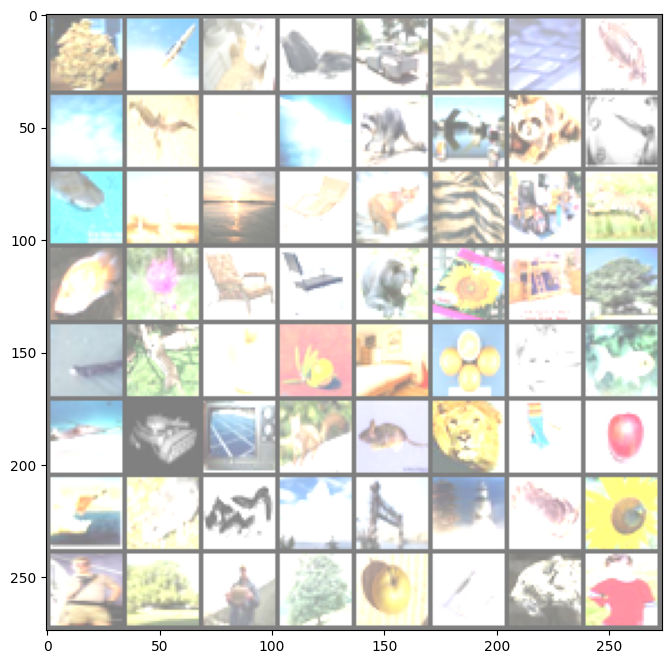

Predict : willow_tree  rocket  rabbit  whale  pickup_truck  palm_tree  keyboard  cockroach  cloud  lizard  snake  cloud  raccoon  bridge  raccoon  clock  shark  rocket    sea  chair    fox  tiger    bus  tiger  aquarium_fish   rose  chair  chair   bear  sunflower    bed  oak_tree  otter  leopard  apple  orange    bed  orange    boy  aquarium_fish    ray   tank  television  squirrel  mouse   lion  chair  apple  rocket  mouse  skunk  cloud  bridge  rocket   crab  sunflower    man  willow_tree  flatfish  oak_tree   pear  telephone  leopard    boy 


In [57]:
lasses = train_dataset.classes 

def imshow(img, labels=None):
    plt.figure(figsize=(12,8))
    img = img / 1 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    
    plt.show()

dataiter = iter(train_data)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images), labels=labels)
print('Predict :',' '.join('%5s ' % classes[labels[j]] for j in range(b_size)))